In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("10_percent_consump.csv", parse_dates=["Trip Start Timestamp"])
data = data.drop("Unnamed: 0", axis=1)
data.head(1)

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,max_temp,min_temp,precip,Trip min,consumption_city_kWh,consumption_combined_kWh
0,2019-01-01,01/01/2019 12:00:00 AM,249.0,0.8,41.970245,-87.713435,41.964652,-87.721017,2.8,2.2,1.0,4,0.22472,0.24104


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10356323 entries, 0 to 10356322
Data columns (total 14 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   Trip Start Timestamp        datetime64[ns]
 1   Trip End Timestamp          object        
 2   Trip Seconds                float64       
 3   Trip Miles                  float64       
 4   Pickup Centroid Latitude    float64       
 5   Pickup Centroid Longitude   float64       
 6   Dropoff Centroid Latitude   float64       
 7   Dropoff Centroid Longitude  float64       
 8   max_temp                    float64       
 9   min_temp                    float64       
 10  precip                      float64       
 11  Trip min                    int64         
 12  consumption_city_kWh        float64       
 13  consumption_combined_kWh    float64       
dtypes: datetime64[ns](1), float64(11), int64(1), object(1)
memory usage: 1.1+ GB


In [4]:
# resample the data for simple hourly prediction
hourly_data = data[[
    "Trip Start Timestamp",
    "Trip Seconds",
    "max_temp",
    "min_temp",
    "precip",
    "Trip min",
    "consumption_city_kWh",
    "consumption_combined_kWh"
    ]].resample("H",on="Trip Start Timestamp").agg({
        "Trip Seconds":"count",
        "max_temp":"mean",
        "min_temp":"mean",
        "precip":"mean",
        "Trip min":"sum",
        "consumption_city_kWh":"sum",
        "consumption_combined_kWh":"sum"
        })
hourly_data["hour"] = hourly_data.index.to_series().apply(lambda x:x.hour)
hourly_data["day"] = hourly_data.index.to_series().apply(lambda x:x.day)
hourly_data.rename(columns={"Trip Seconds":"trip_total","Trip min":"Aggretaged total Minutes Usage"},inplace=True)
hourly_data.dropna(inplace=True)
hourly_data.describe()

,trip_total,max_temp,min_temp,precip,Aggretaged total Minutes Usage,consumption_city_kWh,consumption_combined_kWh,hour,day
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.00000,8759.000000,8759.000000,8759.000000,8759.000000
mean,1182.363626,9.892362,9.835592,0.102066,18910.10298,1624.053027,1741.997783,11.501085,15.721201
std,694.337287,11.702503,11.703214,0.298671,11797.24190,789.391413,846.719946,6.922233,8.797039
min,53.000000,-30.600000,-30.600000,0.000000,716.00000,90.927330,97.530810,0.000000,1.000000
25%,667.000000,1.100000,1.100000,0.000000,9390.00000,1089.259975,1168.366075,6.000000,8.000000
50%,1160.000000,9.400000,9.400000,0.000000,18179.00000,1665.119020,1786.046140,12.000000,16.000000
75%,1540.000000,20.000000,20.000000,0.000000,25924.00000,2016.173795,2162.595815,17.500000,23.000000
max,6186.000000,34.400000,34.400000,1.000000,95478.00000,6075.867000,6517.119000,23.000000,31.000000


In [5]:
#add weekend/day feature
hourly_data["weekday"] = hourly_data.index.to_series().apply(lambda x:0 if x.dayofweek in [5,6] else 1)
#add daytime feature
hourly_data["night"] = hourly_data.index.to_series().apply(lambda x:1 if x.hour < 6 else 0)
hourly_data["noon"] = hourly_data.index.to_series().apply(lambda x:1 if x.hour >= 6 and x.hour < 12 else 0)
hourly_data["afternoon"] = hourly_data.index.to_series().apply(lambda x:1 if x.hour >= 12 and x.hour < 18 else 0)
hourly_data["evening"] = hourly_data.index.to_series().apply(lambda x:1 if x.hour >= 18 and x.hour < 24 else 0)
#add season feature
hourly_data["winter"] = hourly_data.index.to_series().apply(lambda x:1 if x.month < 3 or x.month > 11 else 0)
hourly_data["spring"] = hourly_data.index.to_series().apply(lambda x:1 if x.month >= 3 and x.month < 6 else 0)
hourly_data["summer"] = hourly_data.index.to_series().apply(lambda x:1 if x.month >= 6 and x.month < 9 else 0)
hourly_data["fall"] = hourly_data.index.to_series().apply(lambda x:1 if x.month >= 9 and x.month < 12 else 0)
#add day of week feature
hourly_data["day_of_week"] = hourly_data.index.to_series().apply(lambda x:x.dayofweek)
#discretise day of week feature
hourly_data["mon"] = hourly_data.index.to_series().apply(lambda x:1 if x.dayofweek == 0 else 0)
hourly_data["tue"] = hourly_data.index.to_series().apply(lambda x:1 if x.dayofweek == 1 else 0)
hourly_data["wed"] = hourly_data.index.to_series().apply(lambda x:1 if x.dayofweek == 2 else 0)
hourly_data["thu"] = hourly_data.index.to_series().apply(lambda x:1 if x.dayofweek == 3 else 0)
hourly_data["fri"] = hourly_data.index.to_series().apply(lambda x:1 if x.dayofweek == 4 else 0)
hourly_data["sat"] = hourly_data.index.to_series().apply(lambda x:1 if x.dayofweek == 5 else 0)
hourly_data["sun"] = hourly_data.index.to_series().apply(lambda x:1 if x.dayofweek == 6 else 0)
#remove day column
hourly_data.drop("day",axis=1,inplace=True)
hourly_data.iloc[1:400:100]

,trip_total,max_temp,min_temp,precip,Aggretaged total Minutes Usage,consumption_city_kWh,consumption_combined_kWh,hour,weekday,night,...,summer,fall,day_of_week,mon,tue,wed,thu,fri,sat,sun
Trip Start Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,3259,2.2,1.1,1.0,42220,3529.67704,3786.01528,1,1,1,...,0,0,1,0,1,0,0,0,0,0
2019-01-05 05:00:00,215,1.7,1.7,0.0,3190,444.80515,477.10855,5,0,1,...,0,0,5,0,0,0,0,0,1,0
2019-01-09 09:00:00,1281,-6.1,-6.1,0.0,19742,1577.75912,1692.34184,9,1,0,...,0,0,2,0,0,1,0,0,0,0
2019-01-13 13:00:00,1220,-1.7,-1.7,0.0,18189,1709.19223,1833.32011,13,0,0,...,0,0,6,0,0,0,0,0,0,1


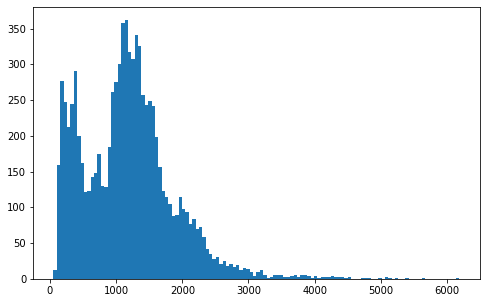

In [6]:
plt.figure(figsize=(8, 5))
plt.hist(hourly_data["trip_total"], bins=120)
plt.show()

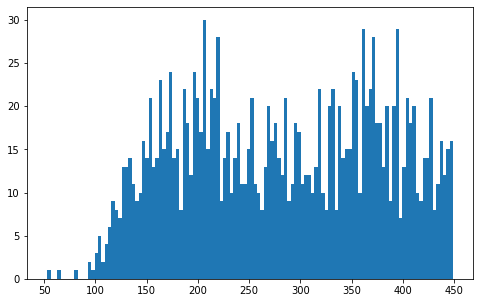

In [7]:
#clear outliers => not part of final prediction since not relevant in aggregated data
#remove hours with too many trips ca. 450
hourly_data_trimmed = hourly_data[(hourly_data["trip_total"] < 450)]
plt.figure(figsize=(8, 5))
plt.hist(hourly_data_trimmed["trip_total"], bins=120)
plt.show()

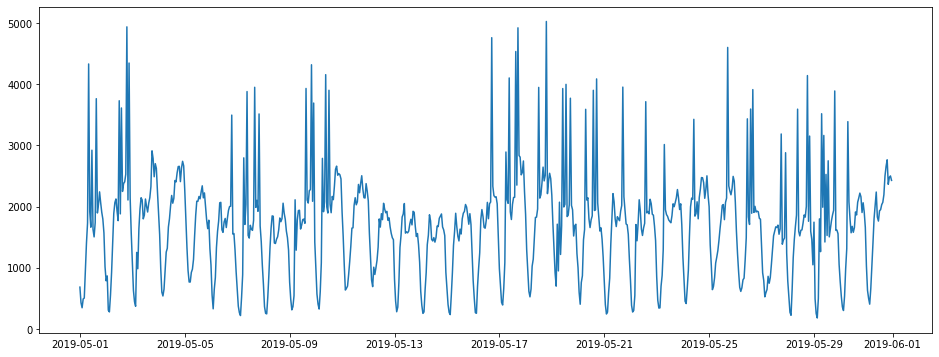

In [8]:
may = hourly_data[(hourly_data.index.month == 5)]
plt.figure(figsize=(16, 6))
plt.plot(may.index, may["consumption_city_kWh"])


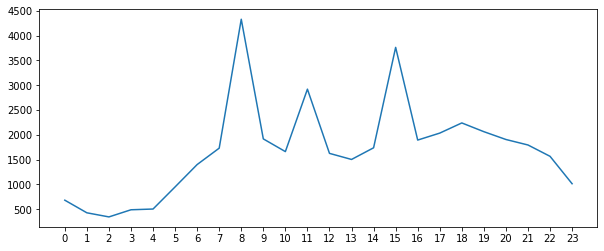

In [9]:
may_first = may[(may.index.to_series().apply(lambda x:x.day in [1]))]
plt.figure(figsize=(10, 4))
plt.plot(may_first.index.to_series().apply(lambda x:f"{x.hour}"), may_first["consumption_city_kWh"])

Features:
max_temp, precip, hour, day/time_of_day, weekday, month, season

In [10]:
def regr(x,y,d):
    #create features
    PF = PolynomialFeatures(degree = d,interaction_only = False, include_bias = True)
    hour_poly = PF.fit_transform(x.reshape(-1,1))
    # create regression
    regression = LinearRegression()
    #normalize values
    regression.fit(hour_poly,y)
    #create curve
    reg_line_points = np.linspace(min(x),max(x),400)
    trans_curve = PF.fit_transform(reg_line_points.reshape(-1,1))
    reg_curve = regression.predict(trans_curve)

    plt.plot(reg_line_points,reg_curve,color="red")
    plt.scatter(x,y,marker="x")
    plt.xlabel("Hour of the day")
    plt.ylabel("Aggregated energy consumption kWh")
    print("MSE: "+ str(mean_squared_error(y,regression.predict(hour_poly))))
    print("MAE: "+ str(mean_absolute_error(y,regression.predict(hour_poly))))
    print("R^2: "+ str(r2_score(y,regression.predict(hour_poly))))
    #print(regression.coef_)

MSE: 335705.1648084318
MAE: 396.96437145022855
R^2: 0.4612059234326512


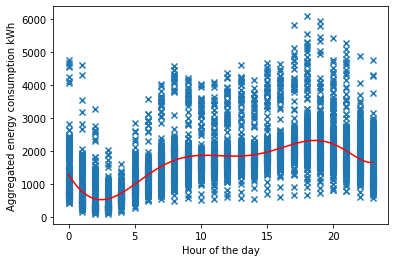

In [11]:
regr(hourly_data["hour"].values,hourly_data["consumption_city_kWh"],7)

In [12]:
#first test training
featured_data = hourly_data[[
    #"max_temp",
    #"min_temp",
    "precip",
    "hour",
    "weekday",
    #"night",
    #"noon",
    #"afternoon",
    #"evening",
    #"winter",
    #"spring",
    #"summer",
    #"fall"
    ]]
X_train, X_test, y_train, y_test = train_test_split(featured_data, hourly_data["consumption_city_kWh"],test_size=0.3, random_state=1)
sc=StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
regr = MLPRegressor(hidden_layer_sizes = [200], random_state=1, max_iter=1000).fit(X_train_scaled, y_train)
print(regr.score(X_test_scaled, y_test))

0.32741036636055476


c:\Users\Adrian\Documents\Studium\Material\Bachelorarbeit\workspace\data_analysis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
#parameter tuning
#gridsearch commented due to very long runtime
"""
regr_grid = MLPRegressor(hidden_layer_sizes = [100], random_state=1, max_iter=1000)
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [300, 500],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
grid = GridSearchCV(regr_grid, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train_scaled, y_train)

print(grid.best_params_) 
resulted in {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
after 35 mins
"""
print("{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}")

{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}


In [17]:
featured_data = hourly_data[[
    "max_temp",
    "min_temp",
    "precip",
    "hour",
    "weekday",
    "day_of_week",
    #"mon",
    #"tue",
    #"wed",
    #"thu",
    #"fri",
    #"sat",
    #"sun"
    #"night",
    #"noon",
    #"afternoon",
    #"evening",
    #"winter",
    #"spring",
    #"summer",
    #"fall"
    ]]
X_train, X_test, y_train, y_test = train_test_split(featured_data, hourly_data["consumption_city_kWh"],test_size=0.3, random_state=1)
sc=StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)
regr = MLPRegressor(hidden_layer_sizes = (100, 50, 30), random_state=1, max_iter=500, learning_rate="constant",solver="adam",activation="relu",alpha=0.05)
regr = regr.fit(X_train_scaled, y_train)
regr.score(X_test_scaled, y_test)

0.6852874870418288

In [15]:
# error
print("Scores of the prediction, may add more later")
print("MSE: "+ str(mean_squared_error(y_test,regr.predict(X_test_scaled))))
print("MAE: "+ str(mean_absolute_error(y_test,regr.predict(X_test_scaled))))
print("R^2: "+ str(r2_score(y_test,regr.predict(X_test_scaled))))
print("#################################")
print("Predicted Data:")
print(y_train.describe())
print("-------------------------------")
print("Real Data:")
print(y_test.describe())

Scores of the prediction, may add more later
MSE: 211370.92278505673
MAE: 245.98142423898773
R^2: 0.6805053472201738
#################################
Predicted Data:
count    6131.000000
mean     1622.760977
std       778.879666
min        90.927330
25%      1089.498740
50%      1665.034750
75%      2013.828280
max      6075.867000
Name: consumption_city_kWh, dtype: float64
-------------------------------
Real Data:
count    2628.000000
mean     1627.067320
std       813.529805
min        97.359940
25%      1085.516983
50%      1666.579700
75%      2018.512288
max      5939.012520
Name: consumption_city_kWh, dtype: float64


In [18]:
# save the model
import pickle
#pickle.dump(sc, open("model_total_city_scaler.sav","wb"))
#filename = 'model_total_city.sav'
#pickle.dump(regr, open(filename, 'wb'))